# COVID-19 Variant Analysis

In [1]:
#Import dependencies
import pandas as pd
import numpy as np
import datetime
from sodapy import Socrata
from matplotlib import pyplot as plt
from pathlib import Path


## Get the Variant Data from API

In [2]:
# Get Data from the API
client = Socrata("data.cdc.gov", None)

# Initialize empty list to store all results
all_results = []

# Parameters for pagination
offset = 0
limit = 10000

while True:
    # Fetch a chunk of data
    results_chunk = client.get("jr58-6ysp", content_type="json", select="variant, creation_date, share, week_ending, usa_or_hhsregion", limit=limit, offset=offset)
    
    # If chunk is empty or smaller than limit, stop fetching
    if not results_chunk or len(results_chunk) < limit:
        all_results.extend(results_chunk)
        break
    
    # Otherwise, add chunk to all results and increment the offset
    all_results.extend(results_chunk)
    # Print running statement to check if we are looping through the API
    print('running...')
    offset += limit

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(all_results)

# Display tail to make sure we get max rows
results_df.tail(5)

running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...
running...

,variant,creation_date,share,week_ending,usa_or_hhsregion
1078797,BN.1,2022-12-09T00:00:00.000,0.023594103753566742,2022-11-19T00:00:00.000,10
1078798,BQ.1,2022-12-09T00:00:00.000,0.20200251042842865,2022-11-19T00:00:00.000,10
1078799,BQ.1.1,2022-12-09T00:00:00.000,0.17415671050548553,2022-11-19T00:00:00.000,10
1078800,Other,2022-12-09T00:00:00.000,0.0,2022-11-19T00:00:00.000,10
1078801,XBB,2022-12-09T00:00:00.000,0.028597155585885048,2022-11-19T00:00:00.000,10


## Clean the Variant data 

In [3]:
# Create a column for the prefix only
results_df['variant_prefix'] = results_df['variant'].str.split('.').str[0]

# Convert the appropriate columns to python datetime
results_df['week_ending'] = pd.to_datetime(results_df['week_ending'], format='%Y-%m-%dT%H:%M:%S.%f')
results_df['creation_date'] = pd.to_datetime(results_df['creation_date'], format='%Y-%m-%dT%H:%M:%S.%f')


In [4]:
# Get all the latest dates for creation_date
latest_dates_df = results_df.groupby(['week_ending', 'usa_or_hhsregion'])['creation_date'].max().reset_index()

# Merge with the original dataframe to get rows with the latest creation_date for each combination
filtered_df = pd.merge(results_df, latest_dates_df, on=['week_ending', 'usa_or_hhsregion', 'creation_date'])

# Reset the index
filtered_df = filtered_df.reset_index(drop=True)



In [5]:
# rename columns and convert the Share column to be in percentage 
filtered_df.rename(columns={'share' : 'Share (%)', 'creation_date' : 'published_date'}, inplace=True)
filtered_df['Share (%)'] = filtered_df['Share (%)'].astype(float) * 100

In [6]:
# Copy the dataframe to a new one called region_df for further manipulation
region_df = filtered_df.copy()

In [7]:
# Define a dictionary to rename the regions to their actual regional names in case you want to use this later
region_mapping = {
    "1": "Region 1 - Boston",
    "2": "Region 2 - New York",
    "3": "Region 3 - Philadelphia",
    "4": "Region 4 - Atlanta",
    "5": "Region 5 - Chicago",
    "6": "Region 6 - Dallas",
    "7": "Region 7 - Kansas City",
    "8": "Region 8 - Denver",
    "9": "Region 9 - San Francisco",
    "10": "Region 10 - Seattle",
}



In [8]:
# Set up dataframe to group by region
region_df['usa_or_hhsregion'].replace(region_mapping, inplace=True)

# Insert column for year if needed
region_df['Year'] = region_df['week_ending'].dt.year

# Filter out irrelevent data 
region_df = region_df[region_df['week_ending'] >= '2021-05-01']
region_df = region_df[region_df['variant'] != 'Other']

# Sort from oldest to latest date
region_df.sort_values(by='week_ending', inplace=True)
region_df.reset_index(drop=True, inplace=True)

region_df.tail()

,variant,published_date,Share (%),week_ending,usa_or_hhsregion,variant_prefix,Year
46125,XBB.1.16.1,2023-09-29,2.941565,2023-09-30,Region 5 - Chicago,XBB,2023
46126,XBB.1.5.70,2023-09-29,4.017762,2023-09-30,Region 5 - Chicago,XBB,2023
46127,XBB.1.5.68,2023-09-29,0.591751,2023-09-30,Region 5 - Chicago,XBB,2023
46128,FD.2,2023-09-29,0.004870,2023-09-30,Region 5 - Chicago,FD,2023
46129,XBB.1.16.1,2023-09-29,3.434272,2023-09-30,Region 9 - San Francisco,XBB,2023


## Get the weekly Deaths data using csv


In [9]:
#get the file path to the excel
covid_deaths_path = Path('Resources/Raw Data/data_table_for_weekly_deaths_and_weekly_%_test_positivity__the_united_states.csv')
deaths_df = pd.read_csv(covid_deaths_path, skiprows=2)

# Delete unecessary column
del deaths_df['Death Data As Of']

In [10]:
# Convert Date to datetime
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'], format='%b %d %Y')

# Remove the years for 2020 because our variant data doesnt extend that far back
deaths_df = deaths_df[deaths_df['Date'] >= pd.Timestamp('2021-05-01')]

# Convert Weekly % Test Positivity to a float and use this to calculate positive test count from total test volume
deaths_df['Weekly % Test Positivity'] = deaths_df['Weekly % Test Positivity'].astype(float) / 100
deaths_df['Total Positive Tests'] = round(deaths_df['Weekly % Test Positivity'] * deaths_df['Test Volume']) 

# Calculate death rate from deaths / positive tests
deaths_df['Death Rate'] = round(((deaths_df['Weekly Deaths'] / deaths_df['Total Positive Tests']) * 100), 1)

# Convert Weekly % Test Positivity back to actual %
deaths_df['Weekly % Test Positivity'] = deaths_df['Weekly % Test Positivity'].astype(float) * 100

deaths_df.sort_values(by='Date', inplace=True)

deaths_df.head()

,Geography,Date,Weekly Deaths,Weekly % Test Positivity,Test Volume,Total Positive Tests,Death Rate
126,United States,2021-05-01,4165,4.1,490898.0,20127.0,20.7
125,United States,2021-05-08,4006,3.7,466777.0,17271.0,23.2
124,United States,2021-05-15,3678,3.0,438635.0,13159.0,28.0
123,United States,2021-05-22,3238,2.7,406644.0,10979.0,29.5
122,United States,2021-05-29,2770,2.2,354739.0,7804.0,35.5


## Plot the COVID death data

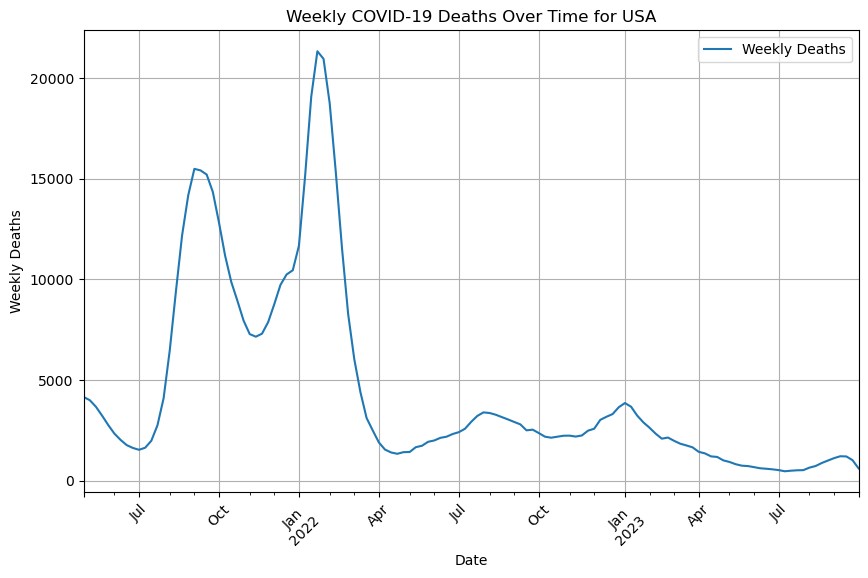

In [11]:
# Use Pandas' built-in plot function
ax = deaths_df.plot(x='Date', y=['Weekly Deaths'], kind='line', figsize=(10, 6))

# Add labels and a title
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Deaths')
ax.set_title('Weekly COVID-19 Deaths Over Time for USA')

# Optional: Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.show()

## Plot Variant % over time for USA (Limit to top variants)

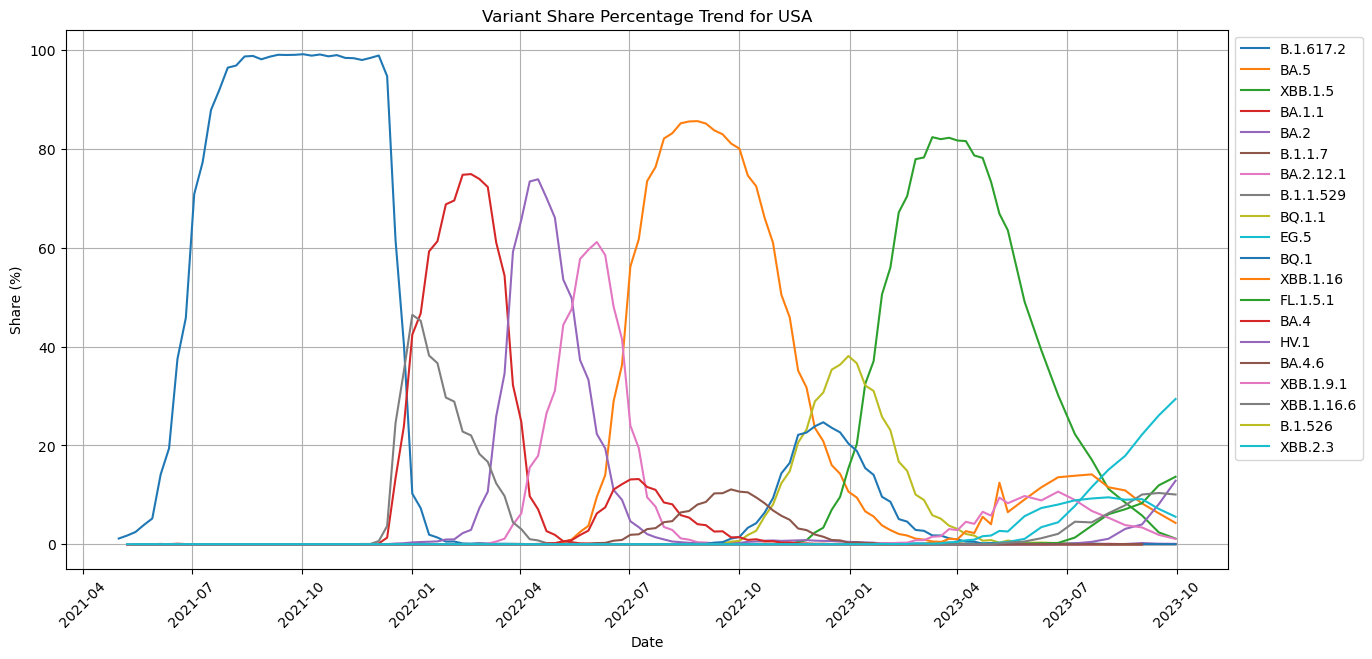

In [12]:
# Extracting the Share (%) values for each combination
grouped_data = region_df.groupby(['variant', 'usa_or_hhsregion','week_ending'])['Share (%)'].sum()

# Selecting the specific region 'USA'
region = 'USA'
plt.figure(figsize=(15, 7))

# Get data specific to 'USA'
region_data = grouped_data[:, region, :]

# Determine the top 20 variant_prefixes based on their maximum Share (%)
top_variants = region_data.groupby(level=0).max().nlargest(20).index

# Loop through each variant_prefix in the top_variants and plot its trend
for variant in top_variants:
    data = region_data.xs(variant, level='variant')
    plt.plot(data.index, data.values, label=variant)

# Setting plot details
plt.title(f'Variant Share Percentage Trend for {region}')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Placing legend outside the plot for clarity
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

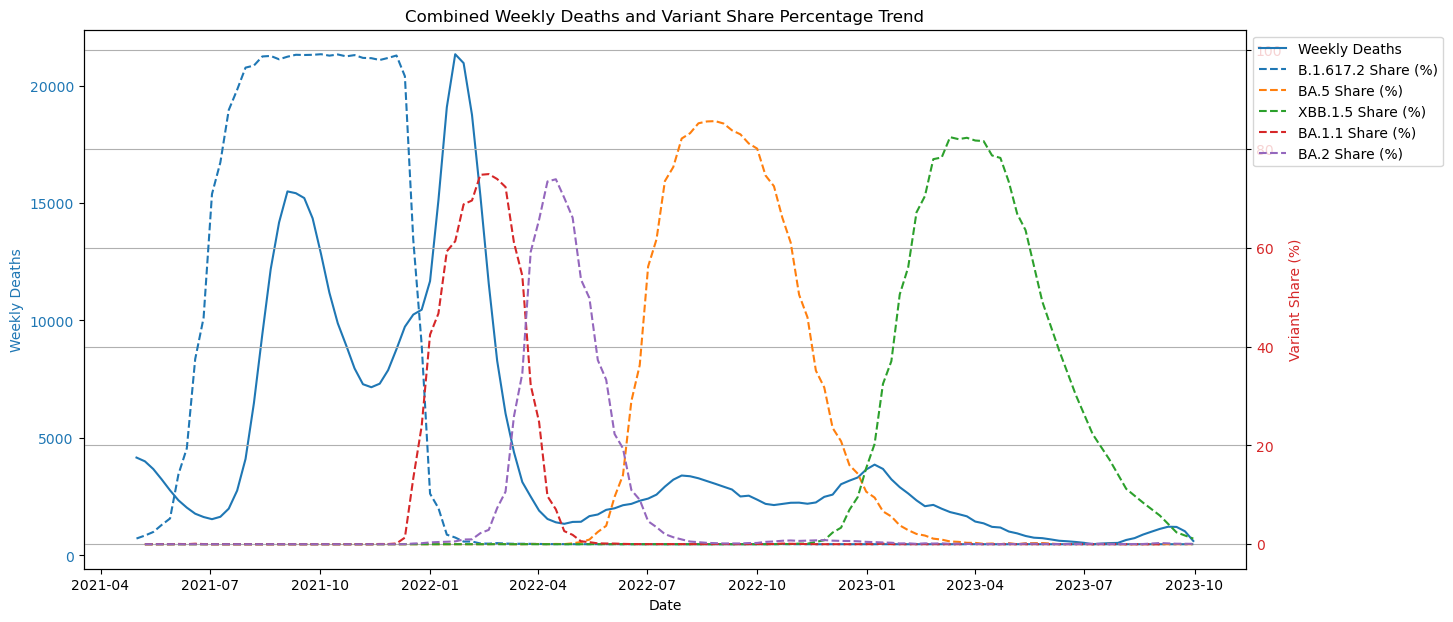

In [13]:
# Convert the 'Date' column in deaths_df to datetime format (if not already)
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'], format='%b %d %Y')

# Create a figure and the first set of axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Create a line plot for the 'Weekly Deaths' data from deaths_df on the first y-axis (ax1)
ax1.plot(deaths_df['Date'], deaths_df['Weekly Deaths'], label='Weekly Deaths', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Deaths', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis (ax2) sharing the same x-axis (ax1)
ax2 = ax1.twinx()

# Extracting the Share (%) values for each combination in region_df
grouped_data = region_df.groupby(['variant', 'usa_or_hhsregion', 'week_ending'])['Share (%)'].sum()

# Selecting the specific region 'USA'
region = 'USA'

# Get data specific to 'USA'
region_data = grouped_data[:, region, :]

# Determine the top 20 variant_prefixes based on their maximum Share (%)
top_variants = region_data.groupby(level=0).max().nlargest(5).index

# Loop through each variant_prefix in the top_variants and plot its trend on the secondary y-axis (ax2)
for variant in top_variants:
    data = region_data.xs(variant, level='variant')
    ax2.plot(data.index, data.values, label=f'{variant} Share (%)', linestyle='--')

# Add labels and a title for the combined plot
ax2.set_ylabel('Variant Share (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends for both sets of data (deaths and shares)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(1, 1))

plt.title('Combined Weekly Deaths and Variant Share Percentage Trend')
plt.xticks(rotation=45)
plt.grid(True)

# Display the combined plot
plt.show()

### Compare each regions distribution of variants to each other to see which variants are most prevalent in which region.

In [14]:
# Filter data to get the start of quarter (SOQ) variant distribution for each of the years.
# Loop through the dataframe and

unique_years = region_df['Year'].unique()
dfs_by_year = {}

for year in unique_years:
    # Filter by year 
    yearly_df = region_df[region_df['Year'] == year]

    # Identify SOQ rows: January, April, July, and October
    temp_filtered_df = yearly_df[yearly_df['week_ending'].dt.month.isin([1, 4, 7, 10])]

    # Get only the first date for each month 
    soq_dates = temp_filtered_df.groupby(temp_filtered_df['week_ending'].dt.month).min()['week_ending'].reset_index(drop=True)

    # Use merge to filter rows from yearly_df that match the SOQ dates
    merged_df = yearly_df.merge(soq_dates, on='week_ending', how='inner')

    # Reset the index
    merged_df = merged_df.reset_index(drop=True)

    # Store this merged dataframe in the dictionary
    dfs_by_year[year] = merged_df

In [15]:
# Mapping of months to reflect start of the quarters
quarter_mapping = {
    1: "Q1 Start",
    4: "Q2 Start",
    7: "Q3 Start",
    10: "Q4 Start"
}

grouped_by_quarter = {}

for year, df in dfs_by_year.items():
    # For each unique start-of-quarter date
    for date in df['week_ending'].unique():
        # Use the month to determine the quarter
        quarter = quarter_mapping[date.month]
        
        # Construct a key based on the year and the quarter
        key = f"{year}: {quarter}"  # This will now create keys like "2023: Q1 Start"
        
        # Filter the dataframe by this date
        filtered_df = df[df['week_ending'] == date]
        
        # Group by the required columns
        grouped = filtered_df.groupby(['variant', 'usa_or_hhsregion'])
        
        grouped_by_quarter[key] = grouped

#### Filter for Q3 start only

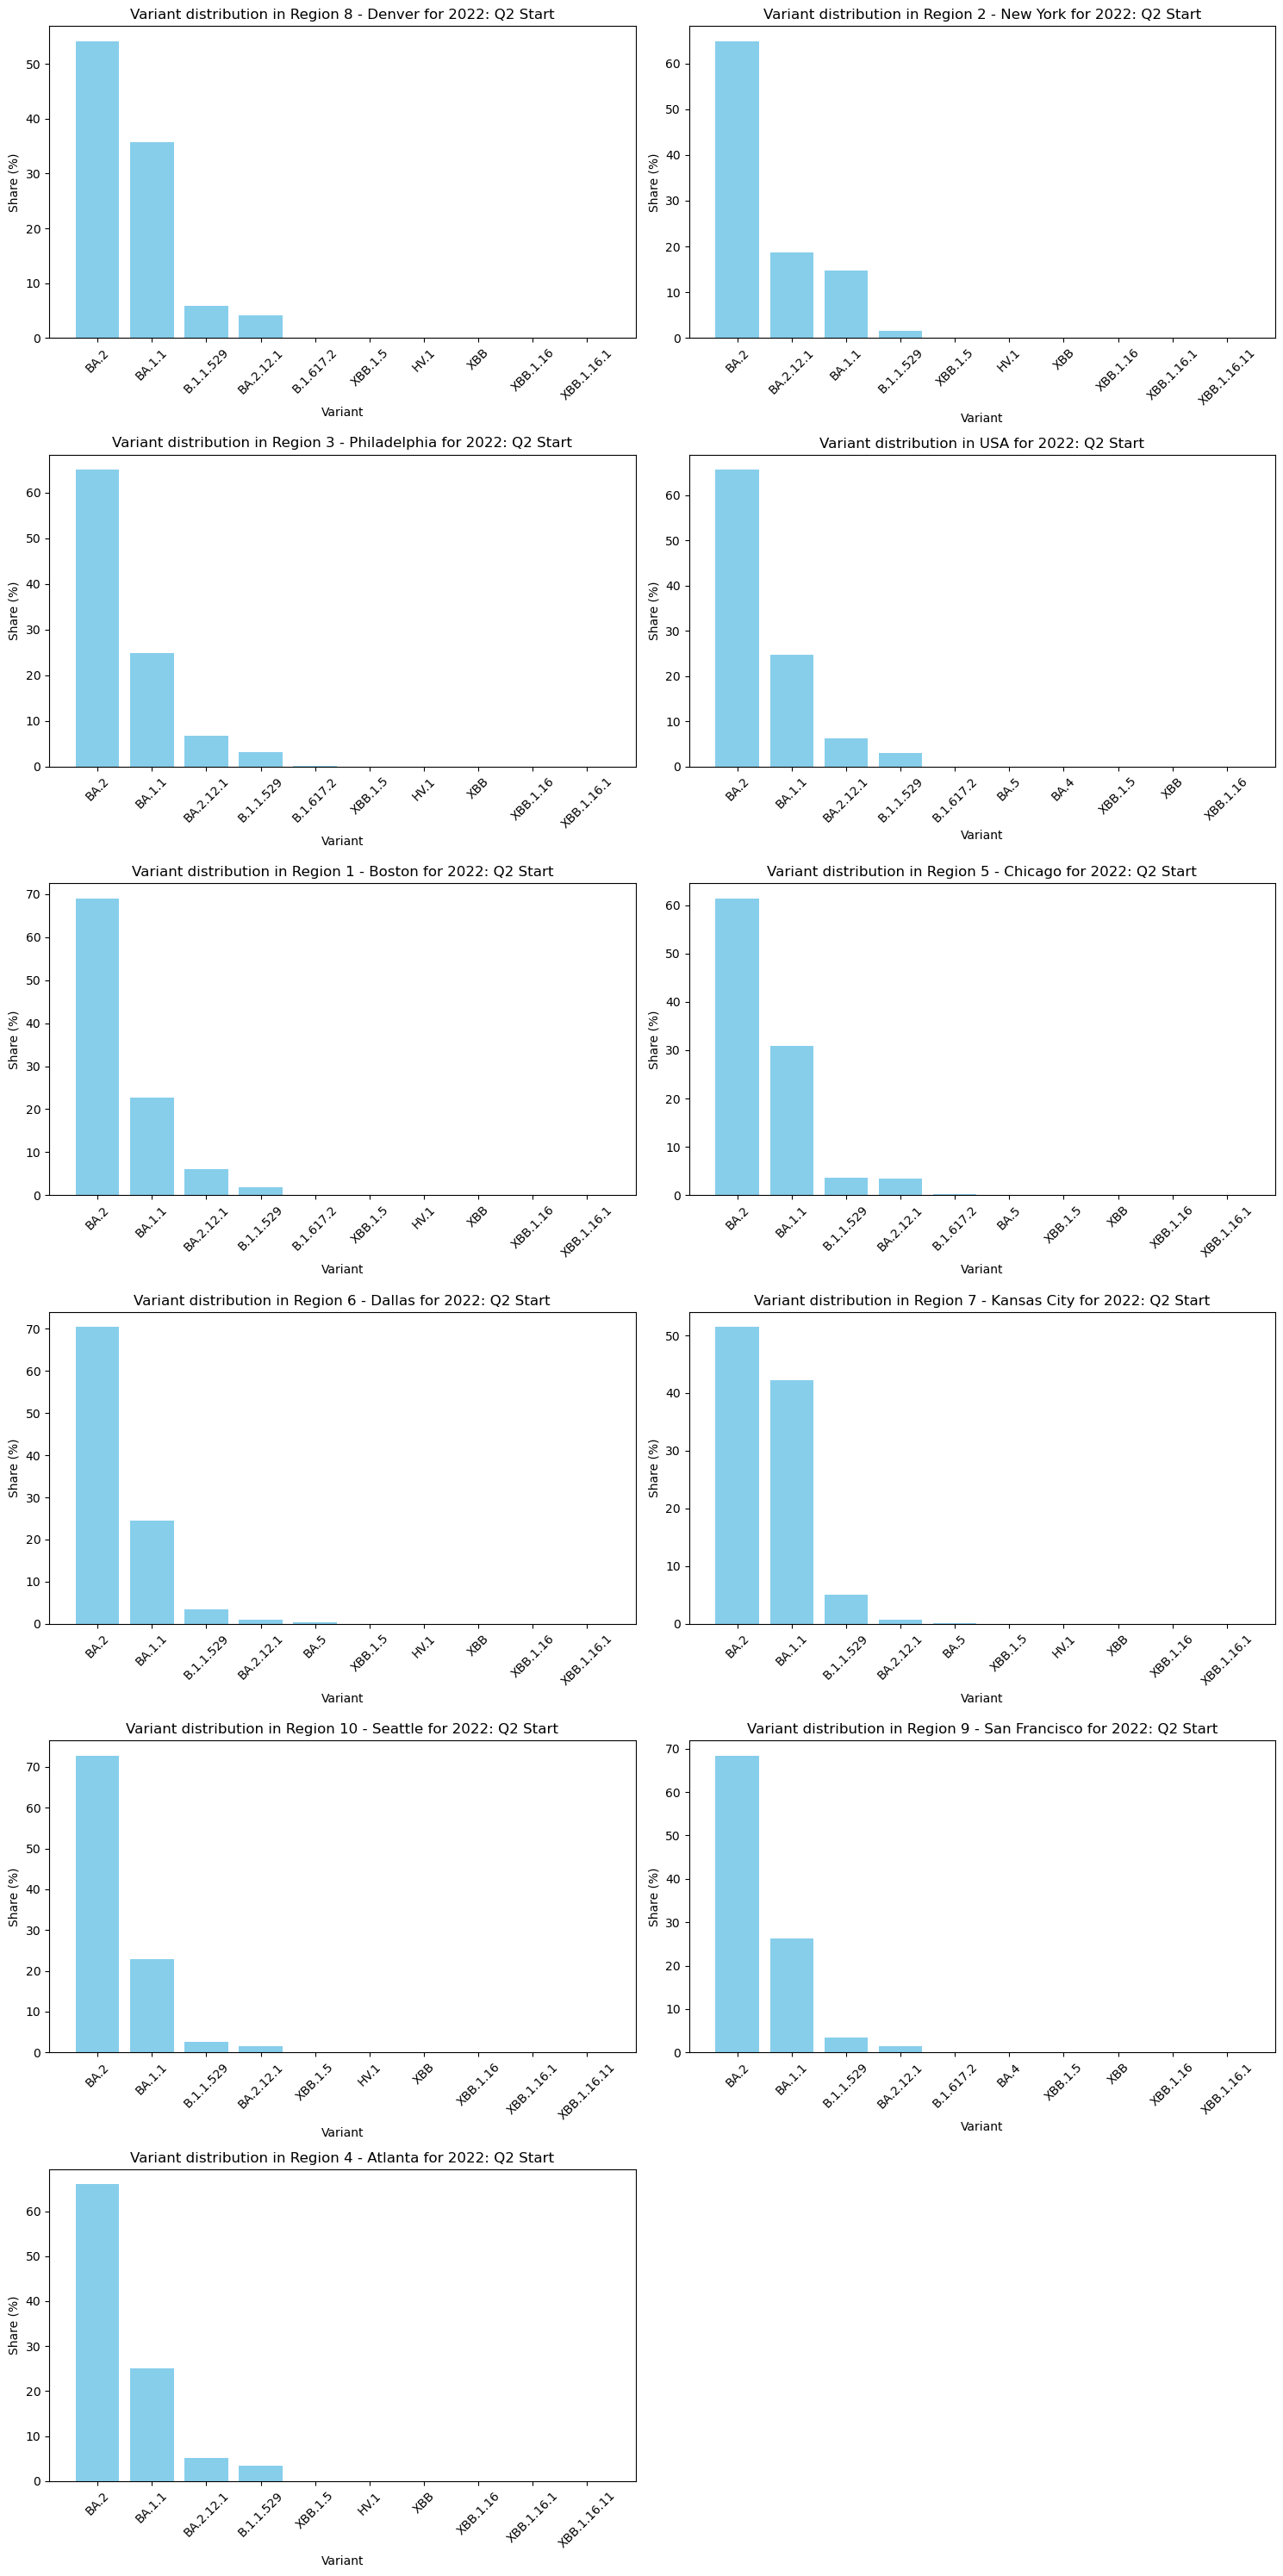

In [16]:
# Get all unique regions
regions = region_df['usa_or_hhsregion'].unique()

# Filter the grouped_by_quarter for 2022 Q2 Start data
grouped_2022_Q2_start = {k: v for k, v in grouped_by_quarter.items() if k == "2022: Q2 Start"}

# Adjust the grid size for the filtered data
n = len(grouped_2022_Q2_start) * len(regions)
cols = 2  # number of columns for the grid
rows = (n // cols) + (n % cols > 0)  # calculate the required number of rows

# Set up a figure with a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))

# Flatten the axes array to easily iterate over it
flattened_axes = axes.ravel()

index = 0
for year, grouped in grouped_2022_Q2_start.items():
    for region in regions:
        data = grouped['Share (%)'].mean().unstack()[region].sort_values(ascending=False)

        # Limit data to the top 10 highest values
        data = data.head(10)
        
        ax = flattened_axes[index]
        ax.bar(data.index, data, color='skyblue')
        ax.set_title(f'Variant distribution in {region} for {year}')
        ax.set_ylabel('Share (%)')
        ax.set_xlabel('Variant')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-labels for better visibility
        
        index += 1

# Hide any remaining unused subplots
for i in range(index, rows * cols):
    flattened_axes[i].axis('off')

plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Variant over regions

### B.1.617.2

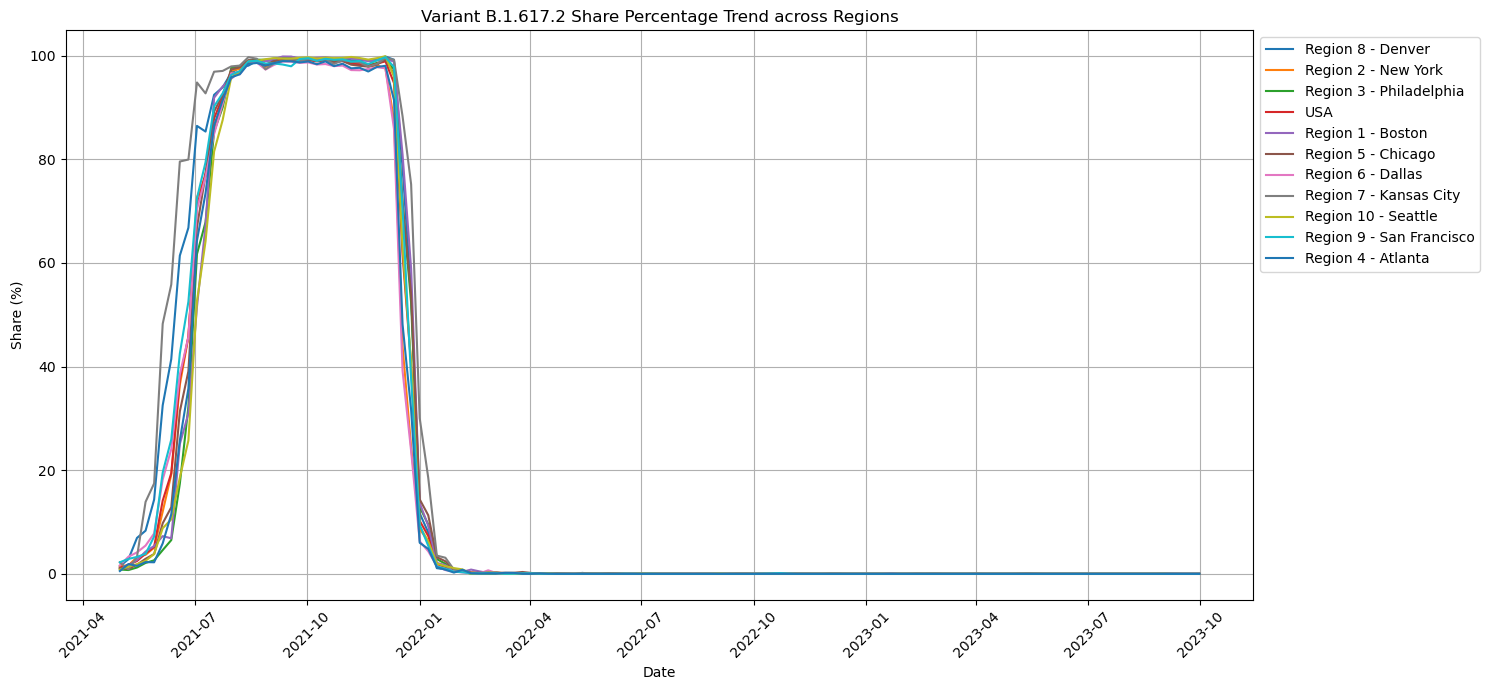

In [17]:
# Extracting the Share (%) values for the variant 'B.1.617.2'
variant_data = grouped_data.xs('B.1.617.2', level='variant')

# Extracting unique regions
regions = region_df['usa_or_hhsregion'].unique()

plt.figure(figsize=(15, 7))

# Loop through each region and plot the variant's trend
for region in regions:
    region_series = variant_data.xs(region, level='usa_or_hhsregion')
    plt.plot(region_series.index, region_series.values, label=region)

# Setting plot details
plt.title(f'Variant B.1.617.2 Share Percentage Trend across Regions')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Placing legend outside the plot for clarity
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
threshold_date = pd.Timestamp('2021-03-27')

# Filter data for 'B.1.617.2' variant
variant_data = grouped_data.xs('B.1.617.2', level='variant')

# Split data based on the threshold_date
historical_data = variant_data[variant_data.index.get_level_values('week_ending') < threshold_date]
post_data = variant_data[variant_data.index.get_level_values('week_ending') >= threshold_date]

# Calculate historical averages for each region
historical_averages = historical_data.groupby(level='usa_or_hhsregion').mean()

# Determine breach dates for each region
breach_dates = {}
for region in historical_averages.index:
    # Get average for the current region
    avg = historical_averages.loc[region]
    
    # Filter the post_data for the current region
    region_post_data = post_data.xs(region, level='usa_or_hhsregion')
    
    # Find the first date where the value is at least 500% of the baseline (i.e., 500% more than the baseline)
    breach_date = region_post_data[region_post_data > 5 * avg].index.min()
    if breach_date:  # Ensure we have a breach date before saving
        breach_dates[region] = breach_date

# Sort regions by breach dates
sorted_regions_by_breach = sorted(breach_dates, key=breach_dates.get)

for i, region in enumerate(sorted_regions_by_breach, 1):
    if region != "USA":
        print(f"{region} breached the historical baseline on {breach_dates[region].date()}")


### BA.5

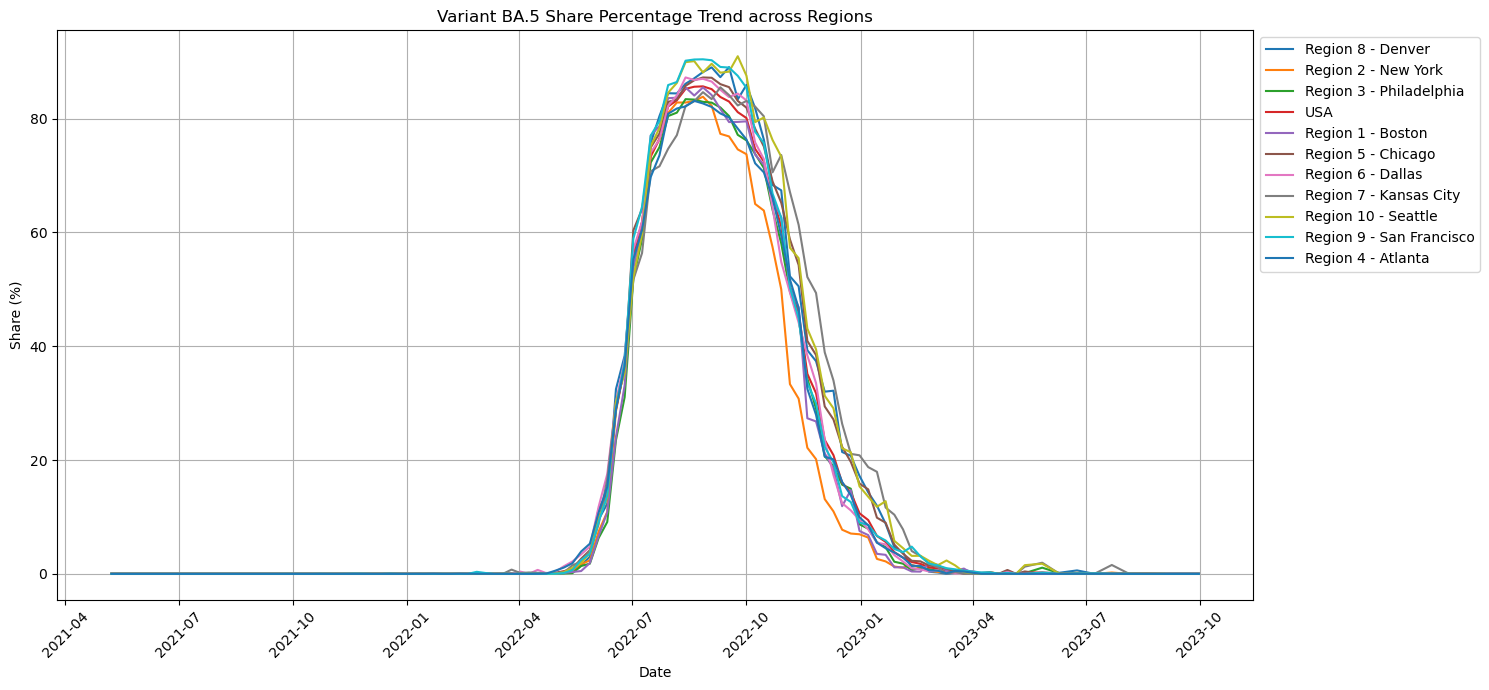

In [19]:
# Extracting the Share (%) values for the variant 'BA.5'
variant_data = grouped_data.xs('BA.5', level='variant')

# Extracting unique regions
regions = region_df['usa_or_hhsregion'].unique()

plt.figure(figsize=(15, 7))

# Loop through each region and plot the variant's trend
for region in regions:
    region_series = variant_data.xs(region, level='usa_or_hhsregion')
    plt.plot(region_series.index, region_series.values, label=region)

# Setting plot details
plt.title(f'Variant BA.5 Share Percentage Trend across Regions')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Placing legend outside the plot for clarity
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
threshold_date = pd.Timestamp('2022-04-23')

# Filter data for 'BA.5' variant
variant_data = grouped_data.xs('BA.5', level='variant')

# Split data based on the threshold_date
historical_data = variant_data[variant_data.index.get_level_values('week_ending') < threshold_date]
post_data = variant_data[variant_data.index.get_level_values('week_ending') >= threshold_date]

# Calculate historical averages for each region
historical_averages = historical_data.groupby(level='usa_or_hhsregion').mean()

# Determine breach dates for each region
breach_dates = {}
for region in historical_averages.index:
    # Get average for the current region
    avg = historical_averages.loc[region]
    
    # Filter the post_data for the current region
    region_post_data = post_data.xs(region, level='usa_or_hhsregion')
    
    # Find the first date where the value is at least 500% of the baseline (i.e., 200% more than the baseline)
    breach_date = region_post_data[region_post_data > 5 * avg].index.min()
    if breach_date:  # Ensure we have a breach date before saving
        breach_dates[region] = breach_date

# Sort regions by breach dates
sorted_regions_by_breach = sorted(breach_dates, key=breach_dates.get)

for i, region in enumerate(sorted_regions_by_breach, 1):
    if region != "USA":
        print(f"{region} breached the historical baseline on {breach_dates[region].date()}")


Region 1 - Boston breached the historical baseline on 2022-04-23
Region 4 - Atlanta breached the historical baseline on 2022-04-23
Region 6 - Dallas breached the historical baseline on 2022-04-23
Region 8 - Denver breached the historical baseline on 2022-04-23
Region 10 - Seattle breached the historical baseline on 2022-04-30
Region 2 - New York breached the historical baseline on 2022-04-30
Region 3 - Philadelphia breached the historical baseline on 2022-04-30
Region 5 - Chicago breached the historical baseline on 2022-04-30
Region 7 - Kansas City breached the historical baseline on 2022-04-30
Region 9 - San Francisco breached the historical baseline on 2022-05-07


### XBB.1.5 

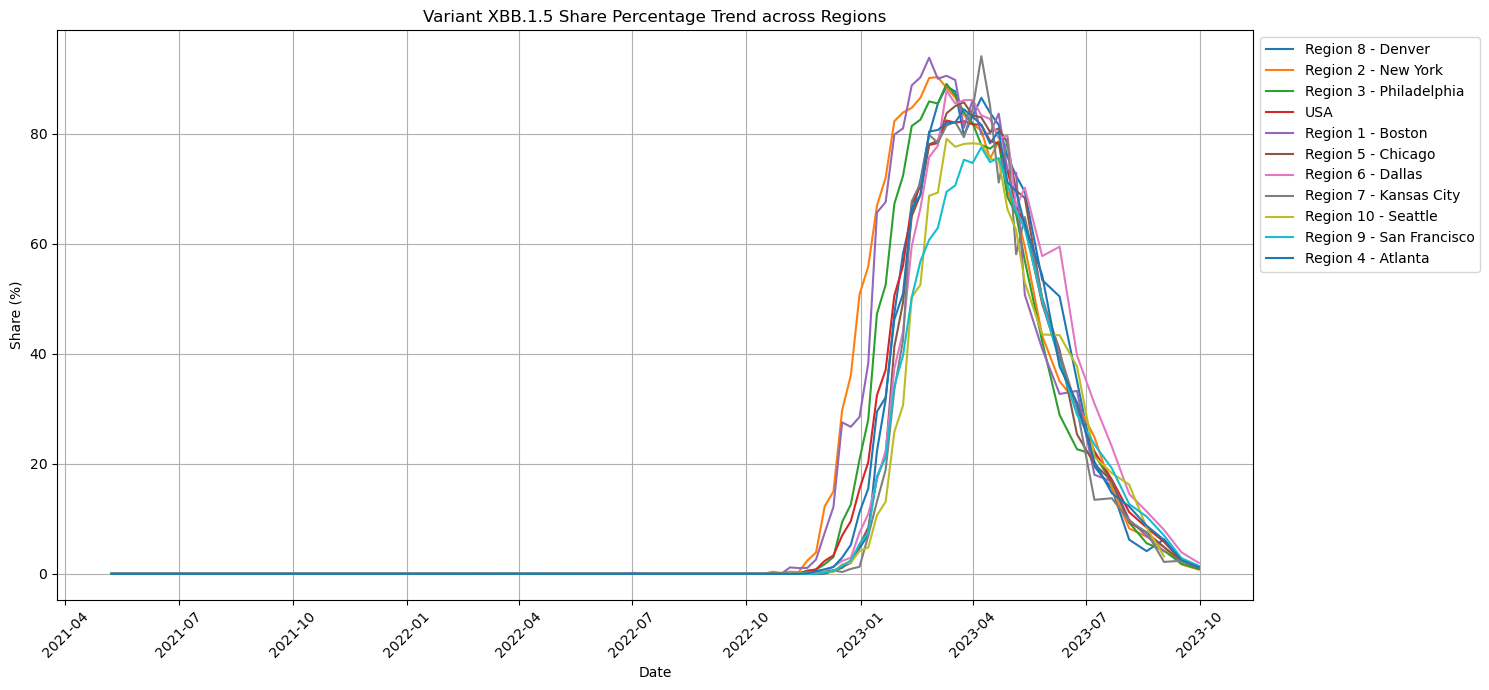

In [21]:
# Extracting the Share (%) values for the variant 'XBB.1.5'
variant_data = grouped_data.xs('XBB.1.5', level='variant')

# Extracting unique regions
regions = region_df['usa_or_hhsregion'].unique()

plt.figure(figsize=(15, 7))

# Loop through each region and plot the variant's trend
for region in regions:
    region_series = variant_data.xs(region, level='usa_or_hhsregion')
    plt.plot(region_series.index, region_series.values, label=region)

# Setting plot details
plt.title(f'Variant XBB.1.5 Share Percentage Trend across Regions')
plt.xlabel('Date')
plt.ylabel('Share (%)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))  # Placing legend outside the plot for clarity
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
threshold_date = pd.Timestamp('2022-10-22')

# Filter data for 'XBB.1.5' variant
variant_data = grouped_data.xs('XBB.1.5', level='variant')

# Split data based on the threshold_date
historical_data = variant_data[variant_data.index.get_level_values('week_ending') < threshold_date]
post_data = variant_data[variant_data.index.get_level_values('week_ending') >= threshold_date]

# Calculate historical averages for each region
historical_averages = historical_data.groupby(level='usa_or_hhsregion').mean()

# Determine breach dates for each region
breach_dates = {}
for region in historical_averages.index:
    # Get average for the current region
    avg = historical_averages.loc[region]
    
    # Filter the post_data for the current region
    region_post_data = post_data.xs(region, level='usa_or_hhsregion')
    
    # Find the first date where the value is at least 500% of the baseline (i.e., 200% more than the baseline)
    breach_date = region_post_data[region_post_data > 5 * avg].index.min()
    if breach_date:  # Ensure we have a breach date before saving
        breach_dates[region] = breach_date

# Sort regions by breach dates
sorted_regions_by_breach = sorted(breach_dates, key=breach_dates.get)

for i, region in enumerate(sorted_regions_by_breach, 1):
    if region != "USA":
        print(f"{region} breached the historical baseline on {breach_dates[region].date()}")


Region 2 - New York breached the historical baseline on 2022-10-22
Region 3 - Philadelphia breached the historical baseline on 2022-10-29
Region 1 - Boston breached the historical baseline on 2022-11-05
Region 10 - Seattle breached the historical baseline on 2022-11-05
Region 9 - San Francisco breached the historical baseline on 2022-11-05
Region 8 - Denver breached the historical baseline on 2022-11-12
Region 4 - Atlanta breached the historical baseline on 2022-11-19
Region 5 - Chicago breached the historical baseline on 2022-11-26
Region 6 - Dallas breached the historical baseline on 2022-11-26
Region 7 - Kansas City breached the historical baseline on 2022-11-26
